<a href="https://colab.research.google.com/github/DkMaria/Fake-News-Detection/blob/main/transe_w_olabel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

KGE1401 with no the information of label

In [ ]:
pip uninstall tensorflow

In [ ]:
pip install "tensorflow>=1.15.2,<2.0"

In [3]:
# install AmpliGraph and other dependencies

%%capture 
# Install AmpliGraph library
! pip install ampligraph

In [4]:
#check if tensorflow is correctly installed 
import tensorflow as tf 
print(tf.version.VERSION)

1.15.5


In [5]:
# All imports used in this notebook
%tensorflow_version 1.x
import ampligraph
import numpy as np
import pandas as pd
import pandas as pd
from ampligraph.datasets import load_from_csv 
from ampligraph.evaluation import train_test_split_no_unseen, evaluate_performance, mr_score, mrr_score, hits_at_n_score
from ampligraph.latent_features import TransE
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score
from ampligraph.utils import create_tensorboard_visualizations 

TensorFlow is already loaded. Please restart the runtime to change versions.


In [6]:
# load data
true = load_from_csv('.', '/content/drive/MyDrive/results15.csv', sep=',') 
false = load_from_csv('.', '/content/drive/MyDrive/resultsf15.csv', sep = ',')

df_true = pd.DataFrame(true, columns = ['id', 'text', 'ratingName', 'author',  'headline', 'named_entities_claim', 'named_entities_article', 'keywords', 'source', 'sourceURL', 'link', 'language'])
df_false = pd.DataFrame(false, columns = ['id', 'text', 'ratingName', 'author', 'headline', 'named_entities_claim', 'named_entities_article', 'keywords', 'source', 'sourceURL', 'link', 'language'])

df_true['label'] = 0
df_false['label'] = 1

data = pd.concat([df_false, df_true])
# shuffle the dataset
data = data.sample(frac=1)

# drop data with no additional information
data = data.drop(columns= 'ratingName')
data = data.drop(columns= 'sourceURL')
data = data.drop(columns = 'link')
data.head()

,id,text,author,headline,named_entities_claim,named_entities_article,keywords,source,language,label
3983,http://data.gesis.org/claimskg/claim_review/c2...,'The law says ... when a police officer stops ...,Harry Houck,Former NYPD detective on Sandra Bland's traffi...,"American Civil Liberties Union,CNN Tonight,Dav...",NaN,"Corrections and Updates,Crime",politifact,English,1
8675,http://data.gesis.org/claimskg/claim_review/e0...,A NYC firefighter’s dare to Osama bin Laden br...,Unknown,American Airlines Flight 587 Crash,"11 September 2001 terrorist attacks,American A...","American Airlines Flight 587,Osama bin Laden",ASP Article,snopes,English,1
2842,http://data.gesis.org/claimskg/claim_review/41...,Says Donald Trump 'used undocumented labor to ...,Hillary Clinton,Hillary Clinton correctly claims that Trump To...,"Donald Trump,Hillary Clinton,I'll get,Manhatta...","Donald Trump,Trump Tower","Candidate Biography,Immigration",politifact,English,0
5000,http://data.gesis.org/claimskg/claim_review/7b...,"In the past 20 years, Egypt has made 'great st...",Sameh Shoukry,"Egyptian ambassador claims Egypt has made """"gr...","Cairo,Committee to Protect Journalists,Council...",Egypt,"Foreign Policy,This Week - ABC News",politifact,English,1
384,http://data.gesis.org/claimskg/claim_review/2d...,Some states hit hardest by opioid deaths 'have...,Eric Schneiderman,Do some states have more opioid prescriptions ...,"Alabama,Arkansas,Eric Schneiderman,Kaiser Fami...",opioid,Drugs,politifact,English,0


In [7]:
#knowledge graph creation
# naming entities
data['id'] =  data.id 
data['text'] = data.text 
data['author'] = data.author 
data['headline'] = data.headline 
data['named_entities_claim'] = data.named_entities_claim  
data['named_entities_article'] =  data.named_entities_article 
data['keywords'] =  data.keywords 
data['source'] = data.source 
data['language'] = data.language 

In [8]:
triples = []
for _, row in data.iterrows():
    text = (row['id'], "hasText", row['text'])
    author = (row['id'], "isWrittenBy", row['author'])
    headline = (row['id'], "hasHeadline", row['headline'])
    named_entities_claim = (row['id'], "referredEntities", row["named_entities_claim"])
    keywords = (row['id'], "containKeywords", row['keywords'])
    language = (row['id'], "isWrittenIn", row['language'])
    source = (row['id'], "isLocated", row['source'])

    triples.extend((text, author, headline, named_entities_claim, keywords, language, source))

In [10]:
# split triples to train-valid-test set
# get the validation set of size 500
test_train, X_valid = train_test_split_no_unseen(np.array(triples), 500, seed=0)

# get the test set of size 1000 from the remaining triples
X_train, X_test = train_test_split_no_unseen(test_train, test_size=10000, seed=0)

print('Train set size: ', X_train.shape)
print('Valid set size: ', X_valid.shape)
print('Test set size: ', X_test.shape)

Train set size:  (90678, 3)
Valid set size:  (500, 3)
Test set size:  (10000, 3)


In [11]:
model = TransE(k=150,                                                             # embedding size
               epochs=100,                                                        # Num of epochs
               batches_count= 10,                                                 # Number of batches 
               eta=1,                                                             # number of corruptions to generate during training
               loss='pairwise', loss_params={'margin': 1},                        # loss type and it's hyperparameters         
               initializer='xavier', initializer_params={'uniform': False},       # initializer type and it's hyperparameters
               regularizer='LP', regularizer_params= {'lambda': 0.001, 'p': 3},   # regularizer along with its hyperparameters
               optimizer= 'adam', optimizer_params= {'lr': 0.001},                # optimizer to use along with its hyperparameters
               seed= 0, verbose=True)
tf.logging.set_verbosity(tf.logging.ERROR)
model.fit(X_train)

Average TransE Loss:   0.023688: 100%|██████████| 100/100 [03:29<00:00,  2.10s/epoch]


In [12]:
# Evaluating knowledge embeddings
print('Size of X_test:', X_test.shape)

# Append the Train, Valid and Test set to the X_filter.
''' The model has not "observed" them during training. We do so because, we would like
   to evaluate a test triple against it's corruptions and not against known facts. 
   If we know that the Validation triples and Test triples are facts (and not queries),
   we need to filter these triples out of the generated corruptions. This is the standard 
   procedure that is used to compute the metrics to compete on the leadership board.'''

X_filter = np.concatenate([X_train, X_valid], 0)

ranks = evaluate_performance(X_test, 
                             model=model,
                             filter_triples=X_filter)

Size of X_test: (10000, 3)
WARNING - You are attempting to use 66055 distinct entities to generate synthetic negatives in the evaluation
    protocol. This may be unnecessary and will lead to a 'harder' task. Besides, it will lead to a much slower
    evaluation procedure. We recommended to set the 'corruption_entities' argument to a reasonably sized set
    of entities. The size of corruption_entities depends on your domain-specific task.


/usr/local/lib/python3.7/dist-packages/ampligraph/evaluation/protocol.py:952: UserWarning: You are attempting to use 66055 distinct entities to generate synthetic negatives in the evaluation
    protocol. This may be unnecessary and will lead to a 'harder' task. Besides, it will lead to a much slower
    evaluation procedure. We recommended to set the 'corruption_entities' argument to a reasonably sized set
    of entities. The size of corruption_entities depends on your domain-specific task.
  warnings.warn(warn_msg % ent_for_corruption_size)
100%|██████████| 10000/10000 [18:45<00:00,  8.89it/s]


In [13]:
mr = mr_score(ranks)
mrr = mrr_score(ranks)

print("MRR: %.2f" % (mrr))
print("MR: %.2f" % (mr))

hits_10 = hits_at_n_score(ranks, n=10)
print("Hits@10: %.2f" % (hits_10))
hits_3 = hits_at_n_score(ranks, n=3)
print("Hits@3: %.2f" % (hits_3))
hits_1 = hits_at_n_score(ranks, n=1)
print("Hits@1: %.2f" % (hits_1))

MRR: 0.33
MR: 2773.85
Hits@10: 0.38
Hits@3: 0.35
Hits@1: 0.30


In [14]:
from sklearn.model_selection import train_test_split

y = data['label']
train_X, X1_test, train_y, y1_test = train_test_split(data['id'], y, test_size=0.20, random_state=42)
X1_train, X_val, y1_train, y_val = train_test_split(train_X, train_y, test_size =0.10, random_state=42)
print('Size training set: ',len(X1_train))
print('Size validation set: ', len(X_val))
print('Size test set: ', len(X1_test))

Size training set:  10406
Size validation set:  1157
Size test set:  2891


In [15]:
# get the embeddings for X1_train
X_train_clf = model.get_embeddings(X1_train)
X_test_clf = model.get_embeddings(X1_test)
X_val_clf = model.get_embeddings(X_val)

In [ ]:
# XGB classifier
clf_model = XGBClassifier(n_estimators=500, max_depth=5, binary="logistic")


eval_set = [(X_train_clf, y1_train),(X_val_clf,y_val)]
clf_model.fit(X_train_clf,y1_train, eval_metric=['error','logloss'], eval_set=eval_set)

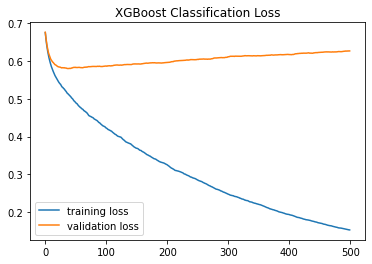

In [17]:
from matplotlib import pyplot
# retrieve performance metrics
results = clf_model.evals_result()

# plot learning curves
pyplot.plot(results['validation_0']['logloss'], label='training loss')
pyplot.plot(results['validation_1']['logloss'], label='validation loss')
# show the legend
pyplot.legend()
pyplot.title('XGBoost Classification Loss')
# show the plot
pyplot.show()

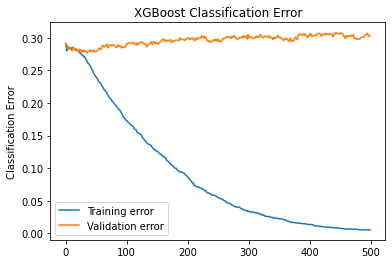

In [18]:
# plot classification error
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Training error')
ax.plot(x_axis, results['validation_1']['error'], label='Validation error')
ax.legend()
pyplot.ylabel('Classification Error')
pyplot.title('XGBoost Classification Error')
pyplot.show()

In [19]:
print('Classification report for TransE - XGBclassifier without label information')
target_names = ['real_news', 'fake_news']
print(classification_report(y1_test,  clf_model.predict(X_test_clf), target_names = target_names))

Classification report for TransE - XGBclassifier without label information
              precision    recall  f1-score   support

   real_news       0.40      0.13      0.20       917
   fake_news       0.69      0.91      0.79      1974

    accuracy                           0.66      2891
   macro avg       0.55      0.52      0.49      2891
weighted avg       0.60      0.66      0.60      2891



   real_news       0.40      0.13      0.20       917
['real_news', '0.40', '0.13', '0.20', '917']
[0.4, 0.13, 0.2]
   fake_news       0.69      0.91      0.79      1974
['fake_news', '0.69', '0.91', '0.79', '1974']
[0.69, 0.91, 0.79]


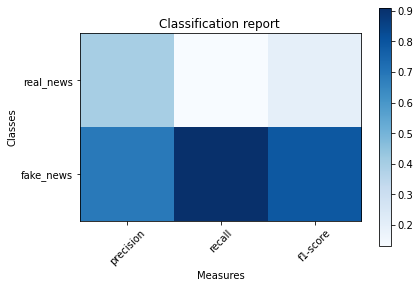

In [20]:
import matplotlib.pyplot as plt
import numpy as np

def plot_classification_report(cr, title='Classification report ', with_avg_total=False, cmap=plt.cm.Blues):

    lines = cr.split('\n')

    classes = []
    plotMat = []
    for line in lines[2 : (len(lines) - 5)]:
        print(line)
        t = line.split()
        print(t)
        classes.append(t[0])
        v = [float(x) for x in t[1: len(t) - 1]]
        print(v)
        plotMat.append(v)

    if with_avg_total:
        aveTotal = lines[len(lines) - 1].split()
        classes.append('avg/total')
        vAveTotal = [float(x) for x in t[1:len(aveTotal) - 1]]
        plotMat.append(vAveTotal)


    plt.imshow(plotMat, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    x_tick_marks = np.arange(3)
    y_tick_marks = np.arange(len(classes))
    plt.xticks(x_tick_marks, ['precision', 'recall', 'f1-score'], rotation=45)
    plt.yticks(y_tick_marks, classes)
    plt.tight_layout()
    plt.ylabel('Classes')
    plt.xlabel('Measures')


ClassificationReport = classification_report(y1_test, clf_model.predict(X_test_clf),target_names = target_names)
plot_classification_report(ClassificationReport)

[0]	validation_0-error:0.291178	validation_0-logloss:0.674519	validation_1-error:0.290406	validation_1-logloss:0.675703
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 10 rounds.
[1]	validation_0-error:0.285701	validation_0-logloss:0.658868	validation_1-error:0.290406	validation_1-logloss:0.660996
[2]	validation_0-error:0.279839	validation_0-logloss:0.645478	validation_1-error:0.288678	validation_1-logloss:0.649485
[3]	validation_0-error:0.281568	validation_0-logloss:0.634353	validation_1-error:0.28522	validation_1-logloss:0.638911
[4]	validation_0-error:0.282433	validation_0-logloss:0.624564	validation_1-error:0.286949	validation_1-logloss:0.629997
[5]	validation_0-error:0.28349	validation_0-logloss:0.615836	validation_1-error:0.283492	validation_1-logloss:0.622732
[6]	validation_0-error:0.284932	validation_0-logloss:0.60844	validation_1-error:0.28522	validation_1-logloss:0.617603

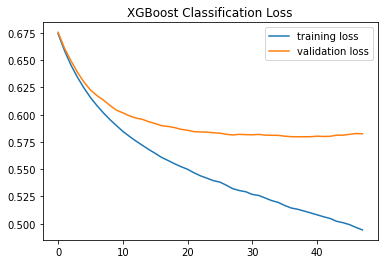

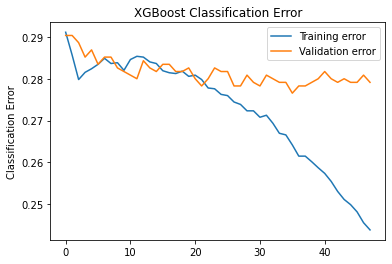

In [21]:
'''XGBOOST -> OVERFITTING
EARLY STOPPING METHOD'''


clf_model.fit(X_train_clf,y1_train, early_stopping_rounds=10, eval_metric=['error','logloss'], eval_set=eval_set)

# retrieve performance metrics
results = clf_model.evals_result()
# plot learning curves
pyplot.plot(results['validation_0']['logloss'], label='training loss')
pyplot.plot(results['validation_1']['logloss'], label='validation loss')
# show the legend
pyplot.legend()
pyplot.title('XGBoost Classification Loss')
# show the plot
pyplot.show()

# plot classification error
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Training error')
ax.plot(x_axis, results['validation_1']['error'], label='Validation error')
ax.legend()
pyplot.ylabel('Classification Error')
pyplot.title('XGBoost Classification Error')
pyplot.show()

   real_news       0.27      0.02      0.03       917
['real_news', '0.27', '0.02', '0.03', '917']
[0.27, 0.02, 0.03]
   fake_news       0.68      0.98      0.80      1974
['fake_news', '0.68', '0.98', '0.80', '1974']
[0.68, 0.98, 0.8]
              precision    recall  f1-score   support

   real_news       0.27      0.02      0.03       917
   fake_news       0.68      0.98      0.80      1974

    accuracy                           0.67      2891
   macro avg       0.48      0.50      0.42      2891
weighted avg       0.55      0.67      0.56      2891



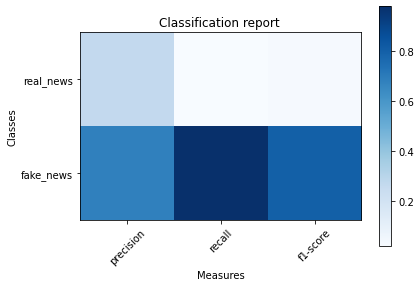

In [22]:
ClassificationReport = classification_report(y1_test, clf_model.predict(X_test_clf),target_names = target_names)
plot_classification_report(ClassificationReport)
print(ClassificationReport)

In [23]:
create_tensorboard_visualizations(model, 'fn_embeddings_transeNo')